In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Conv1D, MaxPooling1D
from keras.callbacks import History
from keras.optimizers import Adam

In [2]:
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Coursework/Assignments/MLAI/MLAI Project/Code and Data/All Data'

# List of patient id's that correspond to file names

NoPainFiles = ['1004103_20070104_2Hz.mat','1008101_20061006_2Hz.mat','1026101_20070831_2Hz.mat',
            '1031101_20071102_2Hz.mat','2002101_20060708_2Hz.mat','2009101_20061028_2Hz.mat',
            '2017101_20061202_2Hz.mat','2023101_20070106_2Hz.mat','2026101_20070210_2Hz.mat',
            '2039102_20070811_2Hz.mat','2051101_20071201_2Hz.mat','2065101_20080927_2Hz.mat',
            '2111101_20100320_2Hz.mat','3008101_20070109_2Hz.mat','3021101_20070412_2Hz.mat',
            '3050101_20080114_2Hz.mat','3058101_20080314_2Hz.mat','3063101_20080629_2Hz.mat',
            '3071101_20090123_2Hz.mat','3073101_20090220_2Hz.mat']

PainFiles = ['1006101_20060915_2Hz.mat','1009101_20061013_2Hz.mat','1013101_20061201_2Hz.mat',
             '1019101_20070608_2Hz.mat','2003101_20060729_2Hz.mat','2006101_20060916_2Hz.mat',
             '2007101_20061014_2Hz.mat','2036101_20070616_2Hz.mat','2047101_20070922_2Hz.mat',
             '2055101_20080405_2Hz.mat','2057101_20080712_2Hz.mat','2066101_20081011_2Hz.mat',
             '2068101_20081129_2Hz.mat','2103101_20100123_2Hz.mat','2105101_20100116_2Hz.mat',
             '3007101_20070108_2Hz.mat','3026101_20070515_2Hz.mat','3029101_20080411_2Hz.mat',
             '3065101_20080727_2Hz.mat','3069101_20090118_2Hz.mat']

#Additive list of all files 

AllFiles = [*NoPainFiles, *PainFiles]

Mounted at /content/drive


In [3]:
def timeDiff(mat,time1,time2): 
    # function returns difference in two times (24hr clock) in 1/2 seconds 
    # str of var name (sleep_end and sleep_onset for example gives duration of sleep)
    # input is list entry, eg: ['05-Jan-2007 06:46:04']
    # for sleep start time to seconds 
    # time2 is later time

    startTime = mat[time1][0]
    startTime = startTime.split()[1]
    startTime = startTime.split(':')
    startTimeSecs = int(startTime[0])*3600 + int(startTime[1])*60 + int(startTime[2])
    # for sleep end time to seconds 
    endTime = mat[time2][0]
    endTime = endTime.split()[1]
    endTime = endTime.split(':')
    endTimeSecs = int(endTime[0])*3600 + int(endTime[1])*60 + int(endTime[2])

    Duration = endTimeSecs - startTimeSecs
    if Duration < 0:
        return (Duration + (24*3600))*2
    else:
        return Duration*2



def processedSignals(mat, signal): 
    # function to process RRI, PPGa, timerel
    # input a string that corresponds to variable name for dataset 
    # Could be 'timerel', 'RRI', or 'PPGa'

    rawSig = mat[signal]
    startTime = timeDiff(mat,'starttime','sleep_onset') #in 1/2 seconds, i.e index
    endTime = timeDiff(mat,'starttime','sleep_end') #in 1/2 seconds, i.e index
    processedSig = rawSig[startTime:endTime]

    return processedSig

def createDataFrames(mat):
    # processing time, making it start at 0 
    time = processedSignals(mat,'timerel')
    t = np.arange(0, 0.5*np.shape(time)[0], 0.5, dtype='float64')
    t = np.reshape(t,(np.shape(time)[0],1))

    # loading RRI/PPGa
    RRI = processedSignals(mat,'RRI')
    PPGa = processedSignals(mat,'PPGa')

    # dataframe of RRI and PPGa over time
    df = pd.DataFrame(np.hstack((t, RRI, PPGa)), columns = ['timerel', 'RRI', 'PPGa'])
    return df

def segment(df):
    # split dataframe into 5 minute signals
    trimmed_size = df.RRI.size - df.RRI.size % 600 - 1
    df_trimmed = df.loc[:trimmed_size]
    num_seconds = df_trimmed.RRI.size / 2 
    num_5mins = int(num_seconds//300)
    split_data = np.array_split(df_trimmed, num_5mins)
    # returned as a list
    return split_data

In [4]:
X = []
y = []

for data_file in AllFiles:
  data = loadmat(os.path.join(data_dir, data_file))
  data_df = createDataFrames(data)
  split_data = segment(data_df.interpolate())

  for sample in split_data:
    X.append(np.array(sample[['RRI','PPGa']]))
    
    if data_file in NoPainFiles:
      y.append(0)
    else:
      y.append(1)

X = np.array(X)
y = np.array(y)

In [5]:
X.shape

(3910, 600, 2)

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=2)

sc = {}
for i in range(X_train.shape[2]):
  sc[i] = StandardScaler()
  X_train[:,:,i] = sc[i].fit_transform(X_train[:,:,i])
  X_val[:,:,i] = sc[i].transform(X_val[:,:,i])
  X_test[:,:,i] = sc[i].transform(X_test[:,:,i])

In [ ]:
# Make sure the model outputs a single value
model = Sequential()
model.add(Conv1D(32, 3, padding='same', activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
# model.add(LSTM(80, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(100))
# model.add(Dense(40))
# model.add(Dense(40, activation='sigmoid'))
# model.add(Dense(40, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
# opt = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 600, 32)           224       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 300, 32)          0         
 1D)                                                             
                                                                 
 lstm_8 (LSTM)               (None, 100)               53200     
                                                                 
 dense_12 (Dense)            (None, 1)                 101       
                                                                 
Total params: 53,525
Trainable params: 53,525
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=2, epochs=20, batch_size=64)

Epoch 1/20
37/37 - 3s - loss: 0.6416 - val_loss: 0.6265 - 3s/epoch - 84ms/step
Epoch 2/20
37/37 - 1s - loss: 0.6216 - val_loss: 0.6283 - 711ms/epoch - 19ms/step
Epoch 3/20
37/37 - 1s - loss: 0.6187 - val_loss: 0.6202 - 745ms/epoch - 20ms/step
Epoch 4/20
37/37 - 1s - loss: 0.6137 - val_loss: 0.6168 - 695ms/epoch - 19ms/step
Epoch 5/20
37/37 - 1s - loss: 0.6107 - val_loss: 0.6158 - 672ms/epoch - 18ms/step
Epoch 6/20
37/37 - 1s - loss: 0.6124 - val_loss: 0.6415 - 727ms/epoch - 20ms/step
Epoch 7/20
37/37 - 1s - loss: 0.6155 - val_loss: 0.6170 - 679ms/epoch - 18ms/step
Epoch 8/20
37/37 - 1s - loss: 0.6012 - val_loss: 0.6010 - 673ms/epoch - 18ms/step
Epoch 9/20
37/37 - 1s - loss: 0.6120 - val_loss: 0.6164 - 702ms/epoch - 19ms/step
Epoch 10/20
37/37 - 1s - loss: 0.6169 - val_loss: 0.6106 - 702ms/epoch - 19ms/step
Epoch 11/20
37/37 - 1s - loss: 0.6039 - val_loss: 0.5939 - 698ms/epoch - 19ms/step
Epoch 12/20
37/37 - 1s - loss: 0.6049 - val_loss: 0.6161 - 690ms/epoch - 19ms/step
Epoch 13/20
37/3

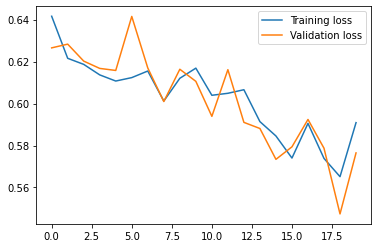

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.show()

In [ ]:
def predict(X, threshold):
  pred = model.predict(X)
  pred = np.squeeze(pred)
  pos_indices = pred >= threshold
  neg_indices = pred < threshold
  pred[pos_indices] = 1
  pred[neg_indices] = 0
  return pred

25/25 [==============================] - 0s 6ms/step


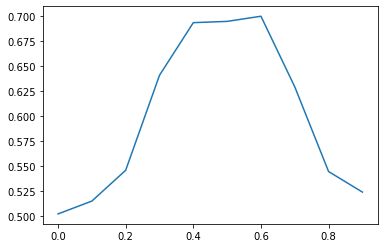

In [ ]:
threshold_arr = np.arange(0, 1, 0.1)
accuracy_arr = []

for threshold in threshold_arr:
  pred_val = predict(X_val, threshold)
  accuracy_arr.append(metrics.accuracy_score(y_val, pred_val))

accuracy_arr = np.array(accuracy_arr)
plt.plot(threshold_arr, accuracy_arr)

In [ ]:
threshold = 0.5
pred_train = predict(X_train, threshold)
pred_val = predict(X_val, threshold)
pred_test = predict(X_test, threshold)

print(metrics.accuracy_score(y_train, pred_train))
print(metrics.accuracy_score(y_val, pred_val))
print(metrics.accuracy_score(y_test, pred_test))

25/25 [==============================] - 0s 6ms/step
0.7127024722932651
0.6943734015345269
0.7148337595907929


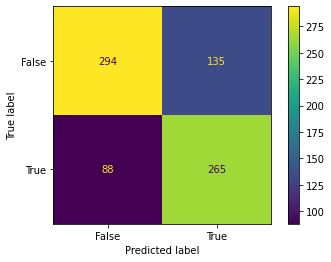

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, pred_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()